In [12]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

device='cuda'

In [13]:
# define resnet model
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)  # update final layer

    def forward(self, x):
        return self.mobilenet(x)
    
def train_model(model, dataloader, epochs=5, scale=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

def gaussian_noise(images, scale):
    return np.random.normal(size=images.shape)*scale + images

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs


def estimate_mi(model, dataloader, scale=0):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            predicted_labels.append(preds)

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)

    mi = lmi.ksg.midd(true_labels, predicted_labels)
    mean_mi = np.nanmean(mi)
    print(f"Estimated Mutual Information: {mean_mi:.4f}")
    return mean_mi


In [14]:
MIs = []

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((224, 224)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform,)


N = len(Caltech101)

train_set, val_set = torch.utils.data.random_split(Caltech101, [1280, N-1280])
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

Files already downloaded and verified


In [15]:

# different downsampling factors
scales = np.logspace(-3, 1, 10)

# process each factor
for p in scales:

    model = ResNetClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=5, scale=p)

    # estimate mutual info
    mi = estimate_mi(model, val_loader, scale=p)
    MIs.append(mi)
    print(f"p {p} -> MI: {mi:.4f}")

print("mutual information results:", MIs)

/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 4.1265
Epoch 2/5, Loss: 2.9750
Epoch 3/5, Loss: 2.4731
Epoch 4/5, Loss: 2.0602
Epoch 5/5, Loss: 1.6859
Estimated Mutual Information: 3.9622
p 0.001 -> MI: 3.9622
Epoch 1/5, Loss: 4.1850
Epoch 2/5, Loss: 2.9882
Epoch 3/5, Loss: 2.4317
Epoch 4/5, Loss: 2.0422
Epoch 5/5, Loss: 1.6537
Estimated Mutual Information: 3.9050
p 0.0027825594022071257 -> MI: 3.9050
Epoch 1/5, Loss: 4.2746
Epoch 2/5, Loss: 3.0560
Epoch 3/5, Loss: 2.4942
Epoch 4/5, Loss: 2.0737
Epoch 5/5, Loss: 1.6972
Estimated Mutual Information: 3.9978
p 0.007742636826811269 -> MI: 3.9978
Epoch 1/5, Loss: 4.0997
Epoch 2/5, Loss: 2.9828
Epoch 3/5, Loss: 2.5388
Epoch 4/5, Loss: 2.1463
Epoch 5/5, Loss: 1.7702
Estimated Mutual Information: 3.8605
p 0.021544346900318832 -> MI: 3.8605
Epoch 1/5, Loss: 4.1890
Epoch 2/5, Loss: 3.0391
Epoch 3/5, Loss: 2.5361
Epoch 4/5, Loss: 2.1556
Epoch 5/5, Loss: 1.8101
Estimated Mutual Information: 3.8344
p 0.05994842503189409 -> MI: 3.8344
Epoch 1/5, Loss: 4.2717
Epoch 2/5, Loss: 3.19

In [16]:
import pandas as pd
import seaborn as sns

In [17]:
d = {"MIs" : MIs, 
     "Noise scales" : scales
     }

df = pd.DataFrame(data=d)
df

,MIs,Noise scales
0,3.962232,0.001000
1,3.905013,0.002783
2,3.997773,0.007743
3,3.860524,0.021544
4,3.834391,0.059948
5,3.304926,0.166810
6,2.256772,0.464159
7,1.415242,1.291550
8,0.672182,3.593814
9,0.248540,10.000000


<Axes: xlabel='Noise scales', ylabel='MIs'>

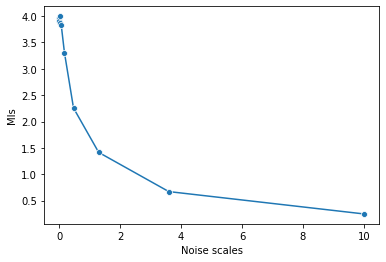

In [18]:
sns.lineplot(x="Noise scales", y="MIs", data=df, marker='o')
# plt.xscale('log')

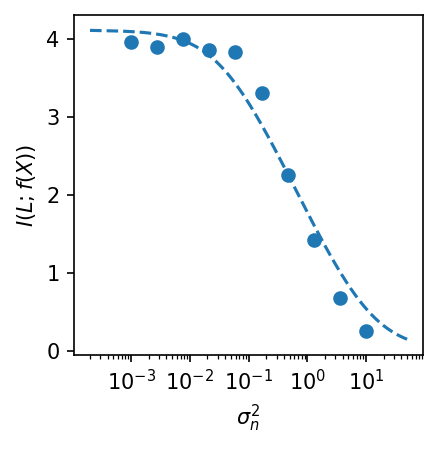

In [30]:
from scipy.optimize import curve_fit
def info_scaling(x, A, B):
    return 0.5 * np.log2(((1/x)*B+ 1)/(1+A*(1/x)))

x_data = df['Noise scales']
y_data = df['MIs']
popt, pcov = curve_fit(info_scaling, x_data, y_data, 
                        p0 = [10**-2, 10**-2], bounds=[(0, 0), (np.inf, np.inf)])

x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)

fig = plt.figure(figsize=(3,3), dpi=150)
plt.xlabel(r'$\sigma_n^2$')
plt.ylabel(r'$I(L; f(X))$')
plt.scatter(x_data, y_data)
plt.plot(x_fit, info_scaling(x_fit, *popt), linestyle='--')
plt.xscale('log')

In [20]:
images, labels = [], []
for batch in data_loader:
    images.append(batch[0].numpy())
    labels.append(batch[1].numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


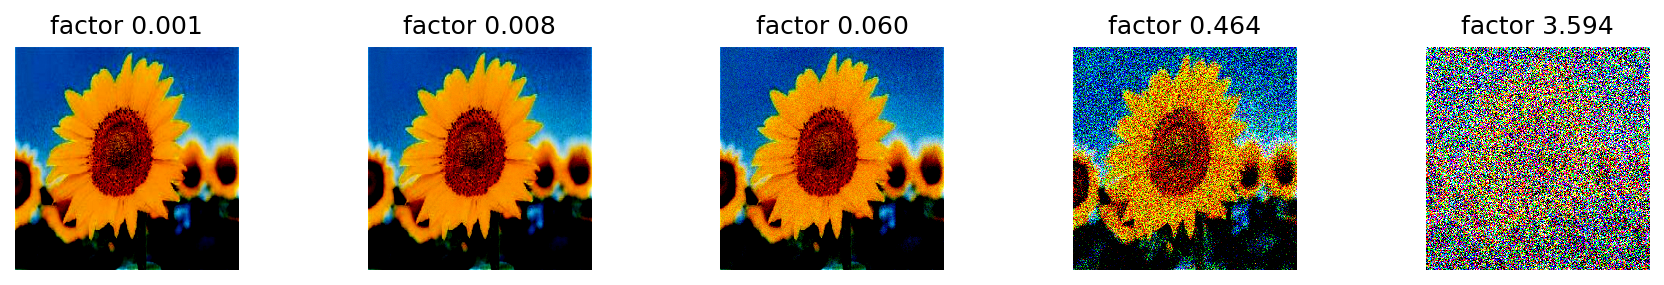

In [36]:
# label 90 is the good label


fig, axes = plt.subplots(1, len(scales[::2]), figsize=(12, 2), dpi=150)  # adjust figsize as needed
batch = 2
for idx, f in enumerate(scales[::2]):
    downsampled = gaussian_noise(images[batch], f)
    for i in range(len(images[0])):
        if labels[batch][i] == 90:
            axes[idx].axis('off')
            axes[idx].imshow(downsampled.transpose(0, 2, 3, 1)[i])
            axes[idx].set_title("factor %.3f" %f)
            break

plt.tight_layout()
plt.show()